In [28]:
import pandas as pd
import numpy as np
import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
password = input("password here")   # Dein MySQL-Passwort hier eintragen
bd = "ufo_sightings"  # Name der Datenbank

# Verwende die IP-Adresse des Hosts
host = "34.32.95.22"  # Der Remote-Host

# Verbindung zu MySQL mit dem 'fee'-Benutzer und der Remote-IP herstellen
connection_string = f'mysql+pymysql://fee:{password}@{host}/{bd}'
engine = create_engine(connection_string)

In [30]:
# DF: DEVELOPMENT UFO SIGHTINGS OVER YEARS

dev_ufo_sightings = pd.read_sql("""
SELECT date, COUNT(us.id) as ufo_sightings
FROM ufo_sightings us
GROUP BY date
ORDER BY date DESC;
""", engine)


In [31]:
# DF: Hypothesis 2 complete

hypo2 = pd.read_sql("""
WITH SightingsWithLag AS (
    SELECT
        d.date, 
        COUNT(DISTINCT m.id) AS movies_total,
        COUNT(DISTINCT CASE WHEN m.ufo_theme = 1 THEN m.id END) AS ufo_movies,
        COUNT(DISTINCT us.id) AS ufo_sightings_months,
        SUM(COUNT(DISTINCT us.id)) OVER (
            ORDER BY RIGHT(d.date, 4) ASC, LEFT(d.date, 2) ASC 
            ROWS BETWEEN CURRENT ROW AND 2 FOLLOWING
        ) AS ufo_sightings_3months
    FROM event_dates d
    LEFT JOIN movies m ON m.date_id = d.date_id 
    LEFT JOIN ufo_sightings us ON d.date_id = us.date_id
    GROUP BY d.date
)
SELECT 
    date, 
    movies_total, 
    ufo_movies, 
    ufo_sightings_months, 
    CASE 
        WHEN ufo_movies >= 1 THEN ufo_sightings_3months
        ELSE NULL 
    END AS ufo_sightings_3months
FROM SightingsWithLag
ORDER BY 
    RIGHT(date, 4) ASC,  
    LEFT(date, 2) ASC;
""", engine)


In [32]:
# DF: Hypo2 filtered for ufo_movies >= 1

hypo2_filtered = pd.read_sql("""WITH SightingsWithLag AS (
    SELECT
        d.date, 
        COUNT(DISTINCT m.id) AS movies_total, 
        COUNT(DISTINCT CASE WHEN m.ufo_theme = 1 THEN m.id END) AS ufo_movies, 
        COUNT(DISTINCT us.id) AS ufo_sightings_months,  
        SUM(COUNT(DISTINCT us.id)) OVER (
            ORDER BY RIGHT(d.date, 4) ASC, LEFT(d.date, 2) ASC 
            ROWS BETWEEN CURRENT ROW AND 2 FOLLOWING
        ) AS ufo_sightings_3months
    FROM event_dates d
    LEFT JOIN movies m ON m.date_id = d.date_id 
    LEFT JOIN ufo_sightings us ON d.date_id = us.date_id 
    GROUP BY d.date
)
SELECT 
    date, 
    movies_total, 
    ufo_movies, 
    ufo_sightings_months, 
    CASE 
        WHEN ufo_movies >= 1 THEN ufo_sightings_3months
        ELSE NULL 
    END AS ufo_sightings_3months
FROM SightingsWithLag
WHERE ufo_movies >= 1  
ORDER BY 
    RIGHT(date, 4) ASC, 
    LEFT(date, 2) ASC;""", engine) 


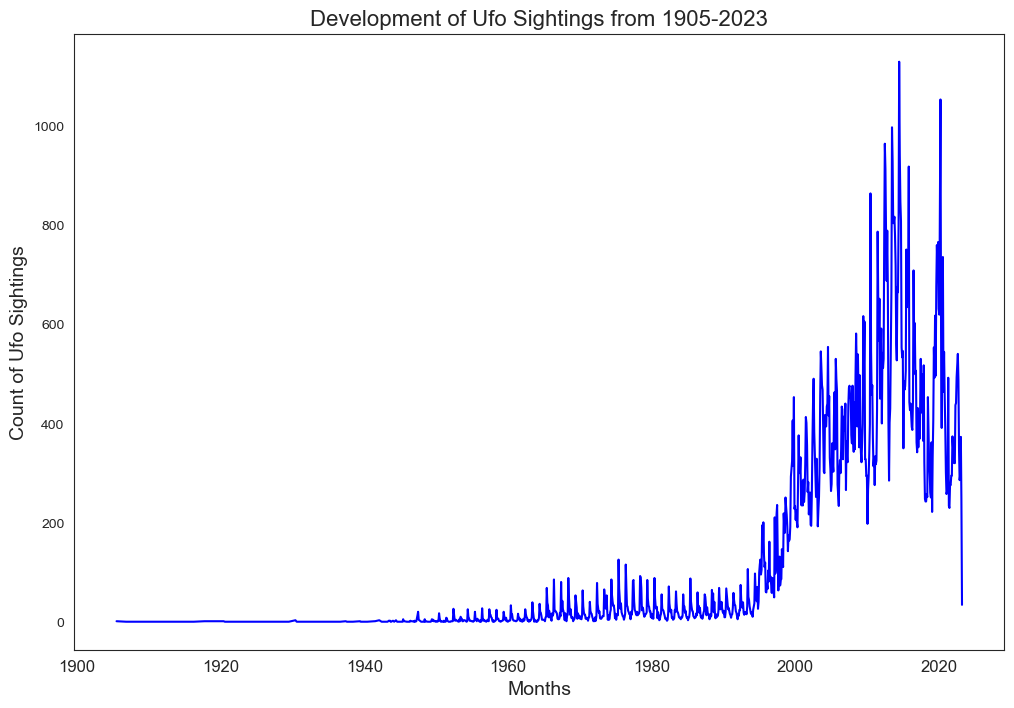

In [33]:
# GRAPH: DEVELOPMENT OF UFO SIGHTINGS OVER YEARS
# Liniendiagramm erstellen
plt.figure(figsize=(12, 8))

# Setze den Stil von Seaborn auf "white"
sns.set_style("white")

# Sicherstellen, dass das Datum im richtigen Format vorliegt
dev_ufo_sightings['date'] = pd.to_datetime(dev_ufo_sightings['date'])

# Liniendiagramm
plt.plot(dev_ufo_sightings['date'], dev_ufo_sightings['ufo_sightings'], linestyle='-', color="blue", label='Ufo Sightings Over Years')

# Achsenbeschriftungen
plt.xlabel('Months', fontsize=14)
plt.ylabel('Count of Ufo Sightings', fontsize=14)

# Titel hinzufügen
plt.title('Development of Ufo Sightings from 1905-2023', fontsize=16)

# Tick-Parameter anpassen
plt.xticks(fontsize=12)
plt.show()


C:\Users\Martijn\AppData\Local\Temp\ipykernel_7688\1666800954.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hypo2_filtered['date'] = pd.to_datetime(hypo2_filtered['date'])


<function matplotlib.pyplot.show(close=None, block=None)>

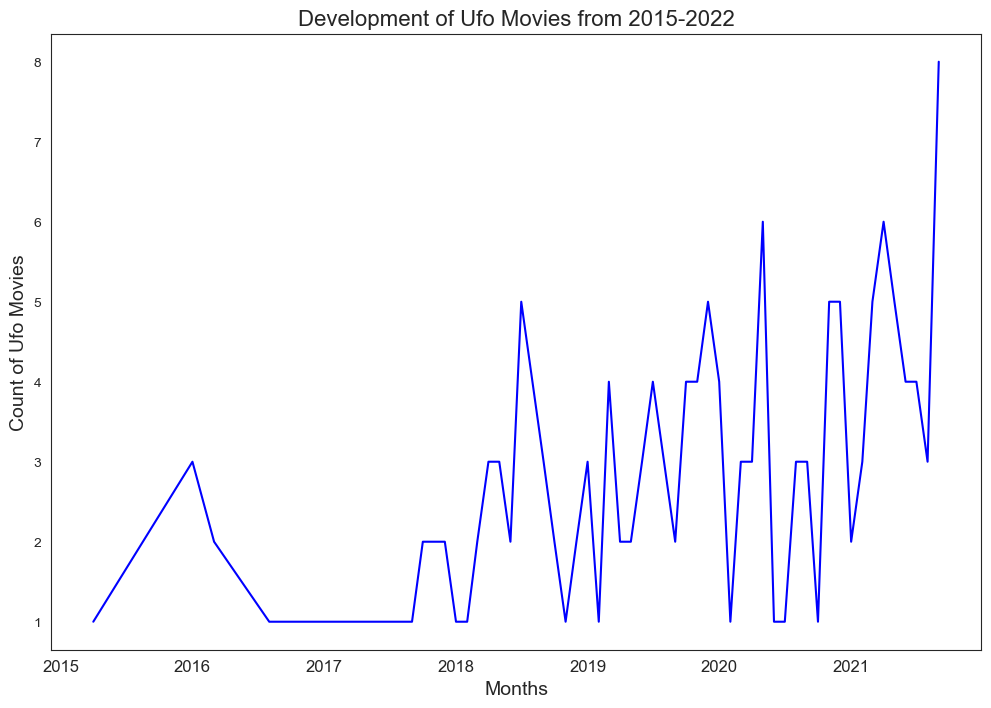

In [34]:
# GRAPH: DEVELOPMENT OF UFO MOVIES RELEASED ON NETFLIX OVER YEARS
# Liniendiagramm erstellen
plt.figure(figsize=(12, 8))

# Setze den Stil von Seaborn auf "white"
sns.set_style("white")

# Sicherstellen, dass das Datum im richtigen Format vorliegt
hypo2_filtered['date'] = pd.to_datetime(hypo2_filtered['date'])

# Liniendiagramm
plt.plot(hypo2_filtered['date'], hypo2_filtered['ufo_movies'], linestyle='-', color="blue", label='Ufo Movies Over Years')

# Achsenbeschriftungen
plt.xlabel('Months', fontsize=14)
plt.ylabel('Count of Ufo Movies', fontsize=14)

# Titel hinzufügen
plt.title('Development of Ufo Movies from 2015-2022', fontsize=16)

# Tick-Parameter anpassen
plt.xticks(fontsize=12)
plt.show


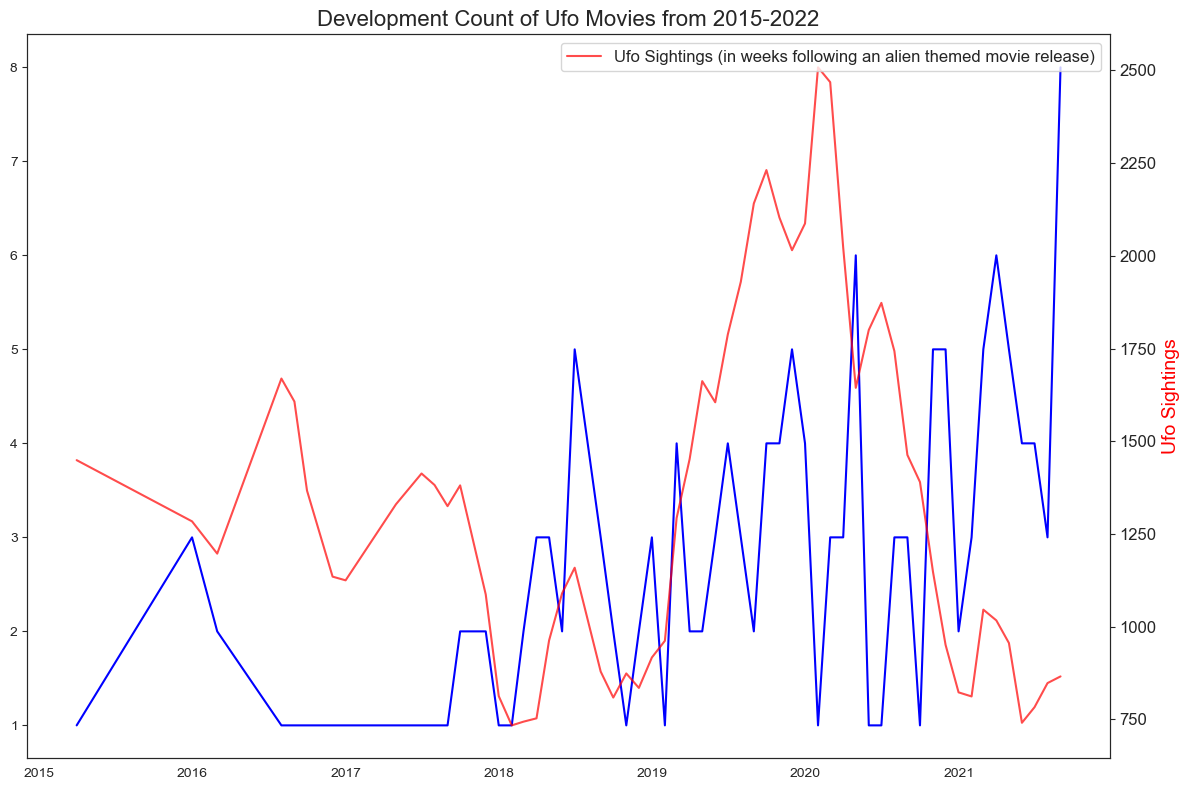

In [35]:
# Sicherstellen, dass die Daten im richtigen Format vorliegen
hypo2_filtered['date'] = pd.to_datetime(hypo2_filtered['date'])

# Setze den Stil von Seaborn auf "white"
sns.set_style("white")

# Erstelle die Figur
plt.figure(figsize=(12, 8))

# Plot für die erste Linie (Ufo Movies)
plt.plot(hypo2_filtered['date'], hypo2_filtered['ufo_movies'], linestyle='-', color="blue", label='Ufo Movies Over Years')

# Erstelle die zweite Achse (für ufo_sightings_3months)
ax2 = plt.gca().twinx()
ax2.plot(hypo2_filtered['date'], hypo2_filtered['ufo_sightings_3months'], linestyle='-', color="red", label='Ufo Sightings (in weeks following an alien themed movie release)', alpha=0.7)

# Achsenbeschriftungen
plt.xlabel('Months', fontsize=14)
plt.ylabel('Count of Ufo Movies', fontsize=14, color='blue')

# Achsenbeschriftungen für die zweite y-Achse
ax2.set_ylabel('Ufo Sightings', fontsize=14, color='red')

ax2.set_facecolor('none')

# Titel hinzufügen
plt.title('Development Count of Ufo Movies from 2015-2022', fontsize=16)

# Tick-Parameter anpassen
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legende anzeigen
plt.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Diagramm anzeigen
plt.xticks(rotation=45, fontsize=12) 
plt.yticks(fontsize=12)
plt.tight_layout()  
plt.show()
